# Calculating Tommy's Portfolio Using Non-Negative Least-Squares

- This allocation is the best one for a number of reasons:
    - 1. No leverage
    - 2. No high turnover
    - 3. All long positions

- Essentially, this is the most realistic, mathematically correct way to optimize your portfolio. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import matplotlib as mpl
import seaborn as sns
import scipy as scs
import math
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.linear_model import QuantileRegressor
from sklearn.decomposition import PCA

from scipy.optimize import lsq_linear
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline



In [2]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6)
        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret.values-rf.values).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    unexplained_var = 1-r_squared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,unexplained_var,tracking_error)
    else:
        return (beta,treynor_ratio,r_squared,unexplained_var,tracking_error)

# Getting the Data

In [3]:
tickers = "AAPL MSFT GS VYM XOM JPM WTRG OXY ^GSPC BUD VNQ HD NFLX"
start = "2003-01-01"
end = "2022-12-01"
rf = pd.DataFrame(yf.download('^IRX', start = start, interval = '1mo', end = end)['Adj Close'])
rf.dropna(inplace = True)
rf = rf *(10**-2)
rf = rf/3
rf.columns = ['3M Treasury']
adj_close = pd.DataFrame(yf.download(tickers, start,interval = '1mo', end = end)["Adj Close"])
adj_close.dropna(inplace = True)
adj_close.columns = ["Apple", "Budweiser", "Goldman", "Home Depot" ,"JP Morgan", "Microsoft", "Netflix", "Occidental Petroleum","Vanguard Real Estate", "Vanguard High Dividend","Essential Utilities", "Exxon", "S&P 500"]
rets = adj_close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  13 of 13 completed


In [4]:
rets = rets.join(rf, how = 'inner')

In [5]:
rets.head()

,Apple,Budweiser,Goldman,Home Depot,JP Morgan,Microsoft,Netflix,Occidental Petroleum,Vanguard Real Estate,Vanguard High Dividend,Essential Utilities,Exxon,S&P 500,3M Treasury
Date,,,,,,,,,,,,,,
2009-08-01,0.029500,0.080947,0.013228,0.052043,0.126100,0.048044,-0.007055,0.024671,0.143232,0.049037,-0.066999,-0.017616,0.033560,0.000433
2009-09-01,0.101896,0.058525,0.116574,-0.023818,0.008284,0.049275,0.058217,0.072503,0.055513,0.021703,0.055157,-0.001749,0.035723,0.000383
2009-10-01,0.016995,0.026992,-0.076919,-0.050353,-0.046782,0.078150,0.157678,-0.027731,-0.035206,-0.020198,-0.124150,0.044600,-0.019762,0.000150
2009-11-01,0.060531,0.065918,-0.002997,0.090474,0.018468,0.060584,0.096913,0.064708,0.065657,0.060733,0.056310,0.047439,0.057364,0.000167
2009-12-01,0.054124,0.034599,-0.002707,0.057383,-0.019299,0.040964,-0.060379,0.006932,0.060189,0.002639,0.082650,-0.086360,0.017771,0.000167


In [6]:
pd.DataFrame([rets.columns, rets.mean()*12], index = ['Asset', 'Yearly Return']).T

,Asset,Yearly Return
0,Apple,0.292956
1,Budweiser,0.085622
2,Goldman,0.121511
3,Home Depot,0.237137
4,JP Morgan,0.154486
5,Microsoft,0.22391
6,Netflix,0.447962
7,Occidental Petroleum,0.142034
8,Vanguard Real Estate,0.126285
9,Vanguard High Dividend,0.130539


<AxesSubplot:title={'center':'Cumulative Growth of $1 Invested'}, xlabel='Date'>

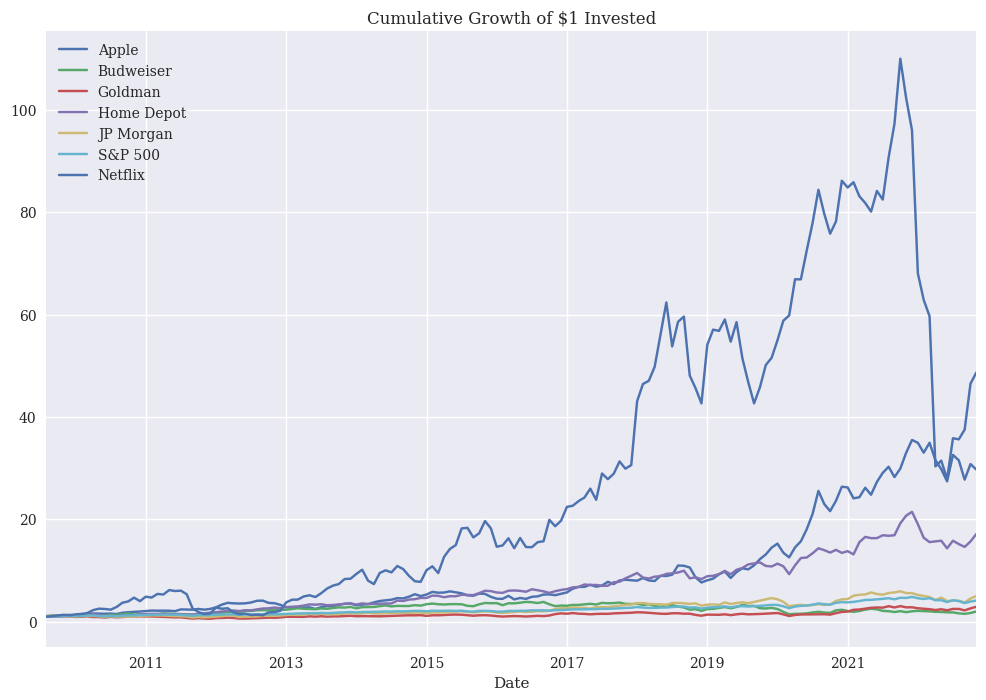

In [7]:
((1+rets[['Apple','Budweiser','Goldman','Home Depot','JP Morgan','S&P 500','Netflix']]).cumprod()).plot(title = "Cumulative Growth of $1 Invested",figsize=(12,8))

<AxesSubplot:title={'center':'Cumulative Growth of $1 Invested'}, xlabel='Date'>

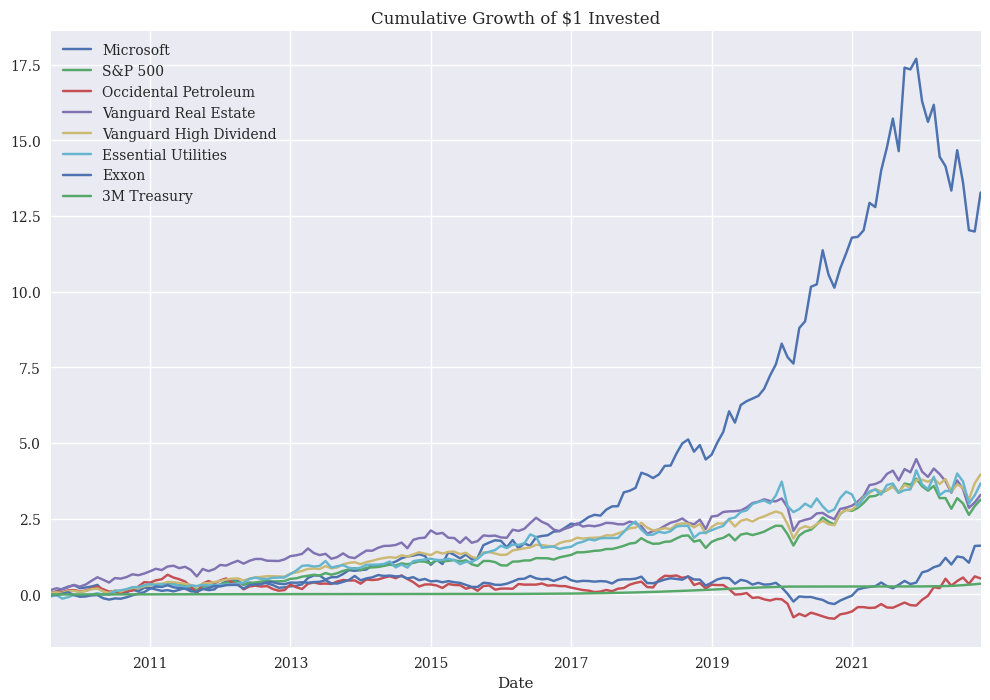

In [8]:
((((1+rets[['Microsoft','S&P 500', 'Occidental Petroleum','Vanguard Real Estate','Vanguard High Dividend','Essential Utilities','Exxon', '3M Treasury']])).cumprod())-1).plot(title = "Cumulative Growth of $1 Invested",figsize=(12,8))

In [9]:
cum_returns = (((1+rets).cumprod())-1)
cum_returns = pd.DataFrame((cum_returns.tail().max()).sort_values(ascending=False), columns = ['Money Multiple'])
cum_returns

,Money Multiple
Netflix,47.673417
Apple,31.571477
Home Depot,16.131557
Microsoft,14.678233
JP Morgan,4.002518
Essential Utilities,3.997798
Vanguard High Dividend,3.971195
Vanguard Real Estate,3.768828
S&P 500,3.182657
Goldman,1.898954


- The only two assets not returning back your money invested since 2003 is Budweiser and Occidental Petroleum. Netflix, if you got in early, would have returned you 47% gross return.At one point Netflix would have returned you an incredible $100$%.

- Over the entire period you actually earn more than Budweiser and Occidental by holding 3-Month Treasuy Bills.

# Univariate Risk Statistics

In [10]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [11]:
performance_summary(rets).sort_values(by = 'Sharpe Ratio', ascending=False)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
3M Treasury,0.022989,0.010104,2.275236,1.789315,2.813032,0.000017,0.000014,0.000000,2009-08-01,2009-08-01,2009-08-01
Home Depot,0.237137,0.212117,1.117958,-0.128208,0.773730,-0.062384,-0.121388,-0.332386,2021-12-01,2022-06-01,NaT
Apple,0.292956,0.270585,1.082677,-0.078655,-0.323692,-0.107935,-0.132282,-0.395421,2012-09-01,2013-06-01,2014-06-01
Microsoft,0.223910,0.215901,1.037095,0.019221,0.302929,-0.080505,-0.109113,-0.305285,2021-12-01,2022-10-01,NaT
Vanguard High Dividend,0.130539,0.139285,0.937210,-0.367452,1.684560,-0.050483,-0.088166,-0.238734,2019-12-01,2020-03-01,2020-12-01
S&P 500,0.117585,0.146521,0.802511,-0.391257,0.669672,-0.069521,-0.090002,-0.247695,2021-12-01,2022-09-01,NaT
Netflix,0.447962,0.563262,0.795300,0.749776,5.198140,-0.197629,-0.313974,-0.798966,2011-05-01,2012-09-01,2013-08-01
Essential Utilities,0.133595,0.186088,0.717913,-0.633430,1.123006,-0.092239,-0.126338,-0.215637,2021-12-01,2022-09-01,NaT
Vanguard Real Estate,0.126285,0.181909,0.694220,-0.351644,1.351813,-0.069824,-0.106074,-0.294162,2021-12-01,2022-09-01,NaT
JP Morgan,0.154486,0.256984,0.601153,-0.266178,0.971895,-0.101988,-0.161171,-0.367319,2021-10-01,2022-09-01,NaT


- Since 2003, Home Depot actually offers the highest sharpe ratio. Apple and Microsoft are greater than 1 as well. Sharpe is important for a variety of reasons because every investor wants to maximize return per risk invested. Even though Netflix averages an incredible 44% yearly return since 2003, it has an extreme amount of tail risk (**look at the excess Kurtosis; for a normally distributed random variable this measure should be 0**) because of the **streaming wars.** Some reasearch ought to go into who will win this battle in the long-run because the market punnished Netflix harshly as you can see that in the cumulative return chart.  

- Disregard the **High Sharpe Ratio for the the 3- Month Treasury Bills.**  They are risk-free for a reason and we expect them to have a high sharpe because their volatility ($\sigma$) is so low. 

- Also you can see that **a ton of assets were just at their peak in 2021/2020**. Now that central banks are raising rates at the fastest rate since the 1980s, global fight against inflation, European Energy Crisis, Ukraine-Russia War, Increased Global Debt, etc there has been a major sell off causing a lot more hightend risk than normal periods - more risk today than 2008 since the global financial crisis was just one **big thing** where now we have several major things to uncover. 

# Performance Summary at Different Times

In [12]:
performance_summary(rets['2014']).sort_values(by = 'Sharpe Ratio', ascending = False)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
3M Treasury,0.000817,0.000141,5.773102,0.408234,-0.459639,0.000014,0.000010,0.000000,2014-01-01,2014-01-01,2014-01-01
Microsoft,0.249793,0.092978,2.686581,0.540550,1.054688,-0.017960,-0.022318,-0.022318,2014-11-01,2014-12-01,NaT
Vanguard Real Estate,0.280148,0.147323,1.901585,-0.156596,2.287078,-0.031932,-0.069059,-0.069059,2014-08-01,2014-09-01,2014-10-01
Apple,0.369117,0.224110,1.647032,-1.126671,0.656988,-0.085790,-0.107697,-0.067867,2014-11-01,2014-12-01,NaT
Vanguard High Dividend,0.131268,0.084423,1.554876,-0.624129,-1.189934,-0.024888,-0.031597,-0.019398,2014-11-01,2014-12-01,NaT
Home Depot,0.284507,0.198782,1.431254,0.932763,1.622708,-0.047384,-0.062089,-0.035353,2014-02-01,2014-03-01,2014-08-01
S&P 500,0.111364,0.081089,1.373352,-0.443025,-0.415766,-0.024545,-0.035583,-0.015514,2014-08-01,2014-09-01,2014-10-01
Essential Utilities,0.165102,0.179834,0.918077,-0.310294,1.459178,-0.070846,-0.093059,-0.096388,2014-06-01,2014-09-01,2014-10-01
Goldman,0.109745,0.121559,0.902814,-1.233192,1.633338,-0.046885,-0.074128,-0.036651,2014-02-01,2014-05-01,2014-06-01
JP Morgan,0.103957,0.141765,0.733304,-0.925388,0.826309,-0.064403,-0.077912,-0.078896,2014-03-01,2014-05-01,2014-09-01


In [13]:
performance_summary(rets['2011']).sort_values(by = 'Sharpe Ratio', ascending = False)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
3M Treasury,0.002017,0.000593,3.403024,0.957466,-0.579768,0.000017,0.000017,0.000000,2011-01-01,2011-01-01,2011-01-01
Home Depot,0.225315,0.167197,1.347606,0.556798,-1.134206,-0.035570,-0.044374,-0.103544,2011-02-01,2011-09-01,2011-11-01
Apple,0.247797,0.203959,1.214935,1.238374,2.104470,-0.044330,-0.055783,-0.055783,2011-10-01,2011-11-01,2011-12-01
Exxon,0.188413,0.188266,1.000780,-0.014706,-1.060802,-0.060736,-0.072315,-0.164307,2011-04-01,2011-09-01,NaT
Vanguard High Dividend,0.107376,0.130652,0.821851,0.598188,0.533732,-0.037810,-0.049389,-0.116716,2011-04-01,2011-09-01,NaT
Budweiser,0.099992,0.182112,0.549072,0.973345,0.193615,-0.041029,-0.041260,-0.155979,2011-04-01,2011-09-01,NaT
Vanguard Real Estate,0.109519,0.242201,0.452181,0.251627,0.835157,-0.083553,-0.116994,-0.181503,2011-05-01,2011-09-01,NaT
Essential Utilities,0.012711,0.093075,0.136563,0.110293,-1.449020,-0.032512,-0.037762,-0.072938,2011-01-01,2011-07-01,NaT
Occidental Petroleum,0.050439,0.425571,0.118520,1.221656,2.757091,-0.143150,-0.175697,-0.371549,2011-04-01,2011-09-01,NaT
S&P 500,0.011461,0.159740,0.071750,0.756211,1.932291,-0.063528,-0.071762,-0.170276,2011-04-01,2011-09-01,NaT


In [14]:
performance_summary(rets['2012'])

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Apple,0.325955,0.303115,1.075349,0.274179,-0.437902,-0.096045,-0.107600,-0.198620,2012-09-01,2012-12-01,NaT
Budweiser,0.409149,0.221021,1.851175,1.022578,0.792073,-0.034612,-0.046897,-0.048207,2012-03-01,2012-05-01,2012-06-01
Goldman,0.419368,0.343223,1.221854,-0.225924,1.600720,-0.116783,-0.168911,-0.230522,2012-03-01,2012-05-01,2012-12-01
Home Depot,0.427099,0.165073,2.587332,-0.893986,-0.619503,-0.046150,-0.047306,-0.047306,2012-04-01,2012-05-01,2012-06-01
JP Morgan,0.372705,0.350008,1.064848,-1.434643,3.190539,-0.136533,-0.223662,-0.274315,2012-03-01,2012-05-01,NaT
Microsoft,0.079006,0.223923,0.352826,0.504175,-0.020263,-0.076773,-0.088382,-0.163913,2012-03-01,2012-11-01,NaT
Netflix,0.674713,1.000125,0.674628,1.334591,1.918283,-0.251130,-0.303373,-0.547088,2012-01-01,2012-09-01,NaT
Occidental Petroleum,-0.152304,0.227860,-0.668410,-0.265236,-0.774079,-0.107116,-0.131002,-0.265870,2012-02-01,2012-11-01,NaT
Vanguard Real Estate,0.168862,0.119326,1.415133,0.021417,-0.449862,-0.034783,-0.045059,-0.045059,2012-04-01,2012-05-01,2012-07-01
Vanguard High Dividend,0.121729,0.081578,1.492170,-1.160910,2.082791,-0.024857,-0.046636,-0.046636,2012-04-01,2012-05-01,2012-07-01


# Measure Assets For Sytematic and Idiosyncratic Risk

- Here I'll regress each asset in your portfolio to get a better understanding if your asset is generating excess return over the market - **on average**.
- The regression equation:

    $r_{i,t} = \alpha + \beta*r_{\text{SPY},t} + \epsilon_t$

    - Will calculate the the Treynor ratio, Information Ratio, Tracking Error, and Market Beta (i,e, *systematic risk*)

In [15]:
assets = rets.columns
market = rets['S&P 500']
risk_free = rets['3M Treasury']

df_list = []
for stock in assets:
    stock_ret = rets[stock]
    reg = regression_based_performance(market, stock_ret, risk_free)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    idiosyncratic_risk = np.round(reg[5], 5)
    tracking_error = np.round(reg[6],4)
    df_list.append(pd.DataFrame([[beta,treynor_ratio,information_ratio,alpha,r_squared,idiosyncratic_risk ,tracking_error]],columns=['Market Beta','Treynor Ratio','Information Ratio','Alpha','r_squared','Idiosyncratic Risk' ,'tracking error'], index = [stock]))
reg_performance = pd.concat(df_list)

reg_performance.sort_values(by  = 'Alpha', ascending = False)




,Market Beta,Treynor Ratio,Information Ratio,Alpha,r_squared,Idiosyncratic Risk,tracking error
Netflix,1.129415,0.376277,0.585360,0.026263,0.086315,0.91369,0.5384
Apple,1.134499,0.237962,0.747319,0.013296,0.377396,0.62260,0.2135
Home Depot,1.003809,0.213336,0.779259,0.009925,0.480785,0.51922,0.1528
Microsoft,0.991561,0.202630,0.671973,0.008943,0.452824,0.54718,0.1597
Essential Utilities,0.644609,0.171585,0.360481,0.004817,0.257605,0.74239,0.1603
Vanguard High Dividend,0.887265,0.121215,0.524256,0.002184,0.871161,0.12884,0.0500
3M Treasury,-0.002465,-0.000000,2.305402,0.001940,0.001278,0.99872,0.0101
Vanguard Real Estate,0.906989,0.113889,0.158084,0.001636,0.533694,0.46631,0.1242
JP Morgan,1.274363,0.103187,0.026285,0.000387,0.527927,0.47207,0.1766
S&P 500,1.000000,0.094595,0.000000,0.000000,1.000000,0.00000,0.0000


- Most assets generate a **positive alpha** in this time period. *Goldman* has the highest systematic risk with a beta coeffcient with $\beta_{goldman}$= 1.44.
- All this means is that if the market increases by 1% on a particular day, then Goldman's expected return is 1.44% 
- ALl of these statistics are scaled to a yearly basis. 

# Correlation Heat Map

Text(0.5, 1.0, 'Asset Correlation Heat Map')

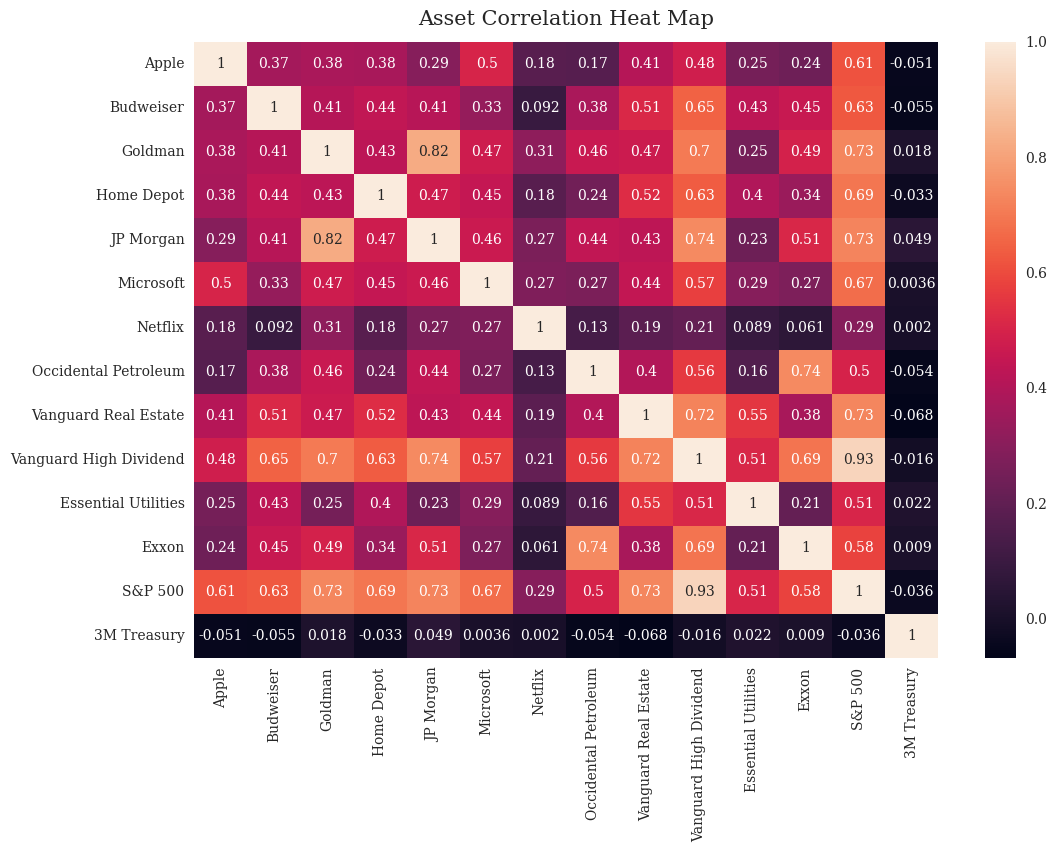

In [16]:
asset_corr = rets.corr()

plt.figure(figsize = (12,8))
heatmap = sns.heatmap(asset_corr,vmax = 1,annot = True)
heatmap.set_title("Asset Correlation Heat Map", fontdict={'fontsize':15}, pad = 12)

In [17]:
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]
sorted_corr.nlargest(len(rets.columns), 'Correlations')

,,Correlations
S&P 500,Vanguard High Dividend,0.933360
Vanguard High Dividend,S&P 500,0.933360
JP Morgan,Goldman,0.823563
Goldman,JP Morgan,0.823563
Exxon,Occidental Petroleum,0.740123
Occidental Petroleum,Exxon,0.740123
Vanguard High Dividend,JP Morgan,0.738586
JP Morgan,Vanguard High Dividend,0.738586
Goldman,S&P 500,0.731361
S&P 500,Goldman,0.731361


In [18]:
sorted_corr.nsmallest(len(rets.columns), 'Correlations')

Correlations
Vanguard Real Estate   3M Treasury                -0.067830
3M Treasury            Vanguard Real Estate       -0.067830
                       Budweiser                  -0.055113
Budweiser              3M Treasury                -0.055113
Occidental Petroleum   3M Treasury                -0.053701
3M Treasury            Occidental Petroleum       -0.053701
                       Apple                      -0.050922
Apple                  3M Treasury                -0.050922
S&P 500                3M Treasury                -0.035752
3M Treasury            S&P 500                    -0.035752
                       Home Depot                 -0.032992
Home Depot             3M Treasury                -0.032992
Vanguard High Dividend 3M Treasury                -0.016380
3M Treasury            Vanguard High Dividend     -0.016380

# Optimal Portfolio VIA Regression

- This is the method Harvard did to optimize their endowment fund. 
- I am going to use excess returns to calculate this optimization because it is more realistic.

In [19]:
rets_excess = rets.subtract(rets['3M Treasury'], axis = 0).drop(columns = ['3M Treasury'])

In [20]:
Ntime, Nassets = rets_excess.shape
# Description of Individual Asset Sharpe Ratios

(rets_excess.mean()/rets_excess.std()).to_frame().describe().rename({0:'Sharpe Ratio Summary'},axis=1).drop(index = ['count']).style.format('{:.2%}'.format)

,Sharpe Ratio Summary
mean,17.60%
std,7.84%
min,6.90%
25%,9.82%
50%,17.15%
75%,22.21%
max,29.07%


In [21]:
y = np.ones((Ntime,1))
x = rets_excess

beta = LinearRegression(fit_intercept=False, positive = True).fit(x,y).coef_.transpose()

beta /= beta.sum()

beta
beta = pd.DataFrame(beta, columns = ['Weight'], index = [rets_excess.columns])
beta
beta_1 = np.matrix(beta)


# Calculating Performance of this Hypothetical Portfolio

In [22]:
def mvo_performance_stats(asset_returns,cov_matrix,port_weights, port_type,period):
    """ 
        Returns the Annualized Performance Stats for given asset returns, portfolio weights and covariance matrix
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
            port_weights = weights of the assets in the portfolio (1 x n) Vector
            port_type = Type of Portfolio | Eg - Tangency or Mean-Variance Portfolio
            period = Monthly frequency
    """
    
    ret = np.dot(port_weights,asset_returns)*period
    vol = np.sqrt(port_weights @ cov_matrix @ port_weights.T)*np.sqrt(period)
    sharpe = ret/vol

    stats = pd.DataFrame([[ret,vol,sharpe]],columns= ["Annualized Return","Annualized Volatility","Annualized Sharpe Ratio"], index = [port_type])
    return stats

In [23]:
mvo_performance_stats(asset_returns=rets_excess.mean(), cov_matrix=rets_excess.cov(), port_weights=np.array(beta).T ,port_type= "Non-Negative Least Squares", period = 12)

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Non-Negative Least Squares,[0.24361774049329565],0 0 0.183592,0 0 1.326949


In [24]:
beta

,Weight
Apple,0.279238
Budweiser,0.000000
Goldman,0.000000
Home Depot,0.364014
JP Morgan,0.000000
Microsoft,0.150608
Netflix,0.118394
Occidental Petroleum,0.000000
Vanguard Real Estate,0.000000
Vanguard High Dividend,0.000000


- If you invest in just those assets, your annualized return would be $\mu$ = $24.36$% with annualized $\sigma$ = $18.359$%

- The weights do make sense given the historical performances of all those assets. Notice how Home Depot receives the highest weight and it has the highest univariate sharpe ratio!

In [25]:
rets_excess.shape

(160, 13)

In [26]:
np.array(beta).shape

(13, 1)

In [27]:
performance_NNLS = rets_excess@(np.array(beta))
performance_NNLS.columns = ['NNLS Portfolio']

In [28]:
performance_summary(performance_NNLS)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
NNLS Portfolio,0.243618,0.183592,1.326949,-0.180386,0.094804,-0.077205,-0.092844,-0.33588,2021-12-01,2022-09-01,NaT


<AxesSubplot:title={'center':'Nonnegative Least Squares Portfolio Return ($10,000 Initial Investment)'}, xlabel='Date'>

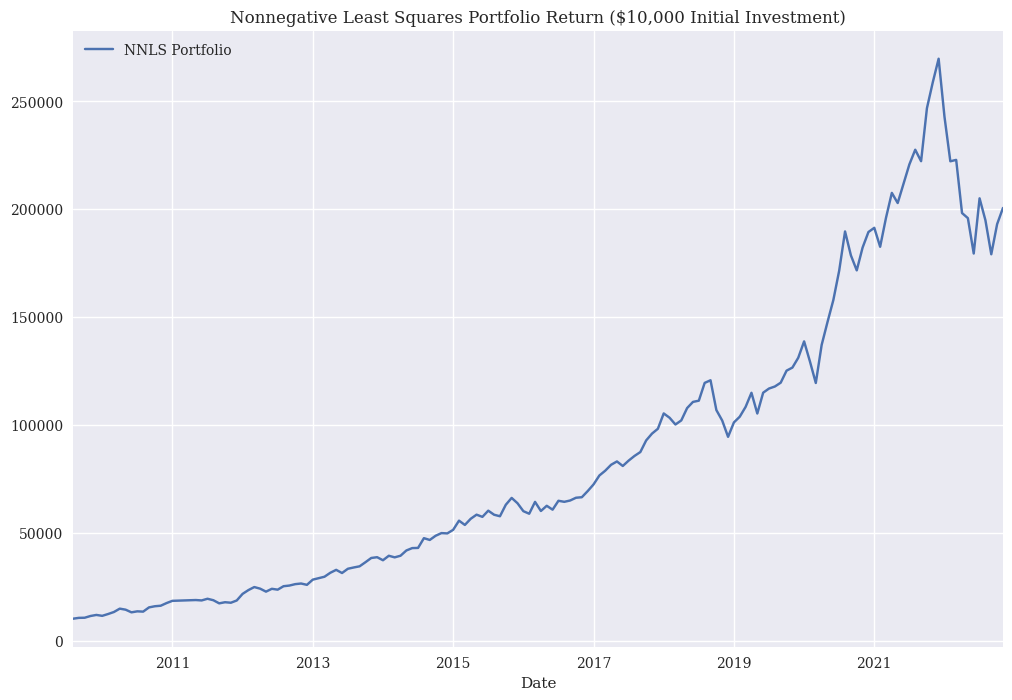

In [29]:
performance = (10000*(1+performance_NNLS).cumprod())
performance.plot(title = 'Nonnegative Least Squares Portfolio Return ($10,000 Initial Investment)', figsize = (12,8))


- You tail risk is not that bad considering you are heavily invested in Tech during this time. Your Max Draw down would have occrued recently, but a gross return of `$1280$% is not too bad over 13 years.

- If you put $\$10,000$ in this portfolio it would have grown to $\$138,000$


In [30]:
10000*13.8

138000.0

- The biggest limitation of your portfolio is that you do not have any diversification. There really isn't a way to find a better sharpe ratio unless you diversify across another asset classes/different sectors of the economy/different types of equities (especially value stocks instead of growth equity).
- Risk aversion is extremly contagious during market stress, and now that we are heading into a riskier world, risk aversion might be prolonged for a long time so getting back into the blue-chip companies that generates lots of cash and have lots of tangible assets unlike growth equity would definitely limit risk for the forseable future. 

